# Quora Question Pairs

This dataset contains pairs of questions from Quora, a popular Q&A website. The goal is to determine whether the two questions in each pair are semantically equivalent.
The dataset is used for training models to identify duplicate questions, which can help improve the efficiency of search and recommendation systems.

The original dataset is available on Kaggle and can be accessed [here](https://www.kaggle.com/c/quora-question-pairs/data).

Data fields:
- `id` - the id of a training set question pair
- `qid1`, `qid2` - unique ids of each question (only available in train.csv)
- `question1`, `question2` - the full text of each question
- `is_duplicate` - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

## Importing Libraries

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

from wordcloud import WordCloud

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (7, 4)

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
PATH = '/content/drive/MyDrive/quora_duplicate_questions/data/'
df_train = pd.read_csv(os.path.join(PATH, 'raw/train.csv.zip'),
                       index_col=0,
                       compression='zip')
df_test = pd.read_csv(os.path.join(PATH, 'raw/test.csv.zip'),
                      index_col=0,
                      compression='zip')

In [7]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323432 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323432 non-null  int64 
 1   qid2          323432 non-null  int64 
 2   question1     323431 non-null  object
 3   question2     323430 non-null  object
 4   is_duplicate  323432 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


In [9]:
df_test.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
305985,429434,429435,Why is beef banned in India and not pork as well?,Is beef banned in india?,0
5193,10230,10231,At what valuation did Homejoy raise money in D...,Should a wealthy founder self-fund his second ...,0
123326,199422,199423,How do we judge?,How do I judge my love?,0
368557,327674,498931,Are Adderall and meth the same?,Are concerta and meth test the same?,0
369226,499645,499646,If you had internet access to only one site fo...,Why is there .co.uk for British internet sites...,0


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80858 entries, 305985 to 7415
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   qid1          80858 non-null  int64 
 1   qid2          80858 non-null  int64 
 2   question1     80858 non-null  object
 3   question2     80858 non-null  object
 4   is_duplicate  80858 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.7+ MB


## Missing values

In [11]:
df_train.isna().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
df_train[df_train['question1'].isna()]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [13]:
df_train[df_train['question2'].isna()]


,qid1,qid2,question1,question2,is_duplicate
id,,,,,
201841,303951,174364,How can I create an Android app?,NaN,0
105780,174363,174364,How can I develop android app?,NaN,0


We have one row with missing values in the `question1` column and two rows with missing values in the `question2` column. We will drop these rows.

In [14]:
df_train.dropna(subset=['question1', 'question2'], inplace=True)
df_train.isna().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
df_test.isna().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
print('Train set:', df_train.shape)
print('Test set:', df_test.shape)

Train set: (323429, 5)
Test set: (80858, 5)


## EDA

### Target distribution

In [16]:
print("\n=== Target Distribution ===")
target_dist = df_train['is_duplicate'].value_counts()
print(target_dist)
print(f"Duplicate percentage: {target_dist[1] / len(df_train) * 100:.2f}%")


=== Target Distribution ===
is_duplicate
0    204019
1    119410
Name: count, dtype: int64
Duplicate percentage: 36.92%


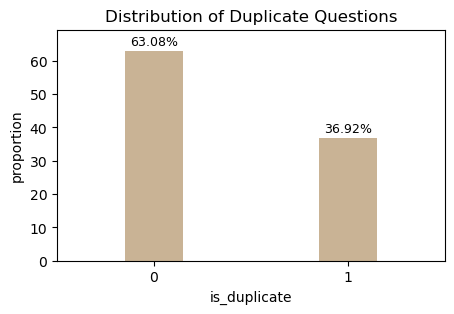

In [ ]:
plt.figure(figsize=(5, 3))
ax = sns.barplot(
    df_train['is_duplicate'].value_counts(normalize=True)*100,
    width=0.3,
    color='tan')
ax.bar_label(ax.containers[0], fmt='%.2f%%' , fontsize=9, padding=2)
ax.margins(y=0.1)
plt.title('Distribution of Duplicate Questions')
plt.show()

### Clean text 
We will clean the text by removing punctuation and converting to lowercase. We will also remove any extra whitespace.

In [17]:
df_train['question1_clean'] = (df_train['question1']
                               .str.replace(r'[^\w\s]', '', regex=True)
                               .str.lower())
df_train['question2_clean'] = (df_train['question2']
                               .str.replace(r'[^\w\s]', '', regex=True)
                               .str.lower())

df_test['question1_clean'] = (df_test['question1']
                              .str.replace(r'[^\w\s]', '', regex=True)
                              .str.lower())
df_test['question2_clean'] = (df_test['question2']
                              .str.replace(r'[^\w\s]', '', regex=True)
                              .str.lower())

### Statistic Text Analysis

Let's analyze the text data to understand the distribution of question lengths, the most common words, and other relevant statistics.

Let's start by checking number of questions in the dataset. 

#### Number of Questions

In [18]:
train_qs = df_train['question1'].to_list() + df_train['question2'].to_list()
test_qs = df_test['question1'].to_list() + df_test['question2'].to_list()
print('Total number of questions:')
print('in Train set:', len(train_qs))
print('in Test set:', len(test_qs))

Total number of questions:
in Train set: 646858
in Test set: 161716


In [19]:
print('Unique questions:')
print('in Train set:', len(set(train_qs)))
print('in Test set:', len(set(test_qs)))

Unique questions:
in Train set: 449361
in Test set: 137701


#### Length of Questions
The next step is to check the distribution of question lengths in the dataset. We will calculate the length of each question and plot the distribution.

In [20]:
df_train['len_question1'] = df_train['question1'].str.len()
df_train['len_question2'] = df_train['question2'].str.len()

In [21]:
palette = {1: '#D1A573', 0: '#73B5D1'}

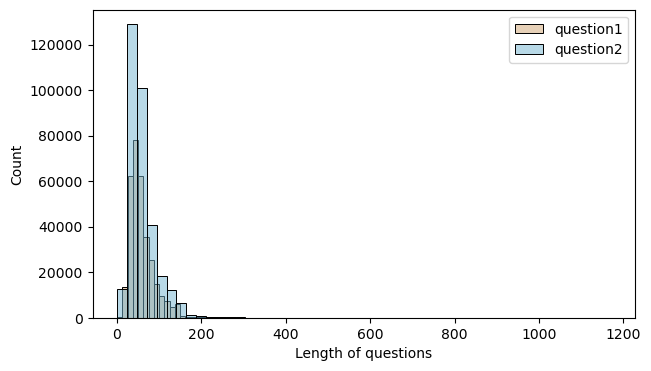

In [ ]:
sns.histplot(df_train['len_question1'],
             bins=50,
             color=palette[1],
             alpha=0.5,
             label='question1')
sns.histplot(df_train['len_question2'],
             bins=50,
             color=palette[0],
             alpha=0.5,
             label='question2')
plt.xlabel('Length of questions')
plt.legend()
plt.show()

In [22]:
temp_df = pd.melt(df_train,
                  value_vars=['len_question1', 'len_question2'],
                  id_vars=['is_duplicate'])
temp_df.head()

,is_duplicate,variable,value
0,0,len_question1,47
1,0,len_question1,62
2,0,len_question1,32
3,0,len_question1,51
4,1,len_question1,159


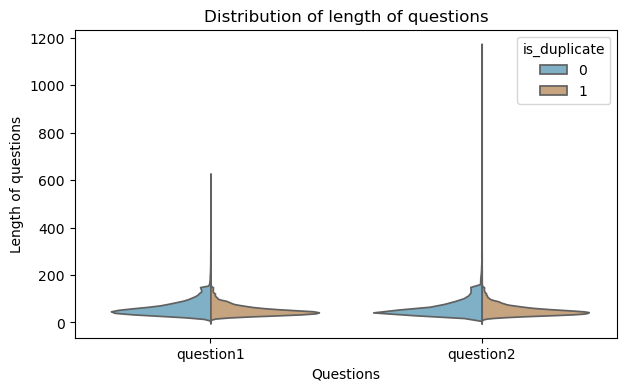

In [ ]:
sns.violinplot(data=temp_df,
               x='variable',
               y='value',
               hue='is_duplicate',
               palette=palette,
               split=True,
               inner=None)
plt.xlabel('Questions')
plt.xticks([0, 1], ['question1', 'question2'])
plt.ylabel('Length of questions')
plt.title('Distribution of length of questions')
plt.show()

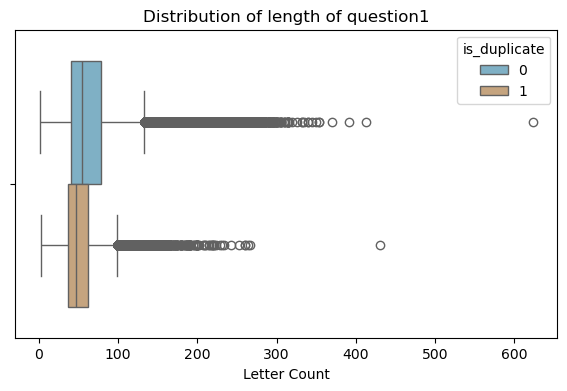

In [ ]:
sns.boxplot(df_train, x='len_question1', hue='is_duplicate', palette=palette)
plt.title('Distribution of length of question1')
plt.xlabel('Letter Count')
plt.show()

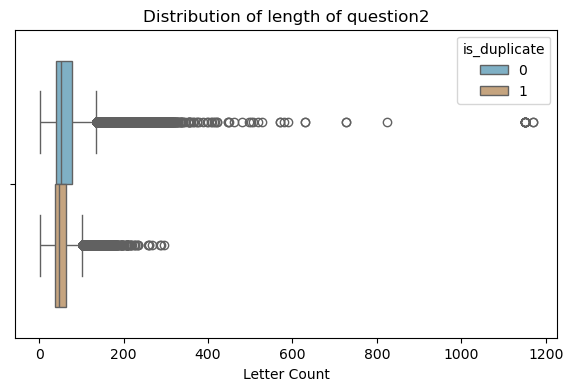

In [ ]:
sns.boxplot(df_train, x='len_question2', hue='is_duplicate', palette=palette)
plt.title('Distribution of length of question2')
plt.xlabel('Letter Count')
plt.show()

Seems like question 2 often longer than question 1. But the length of questions, that have duplicate is shorter than the length of questions that are not duplicate.

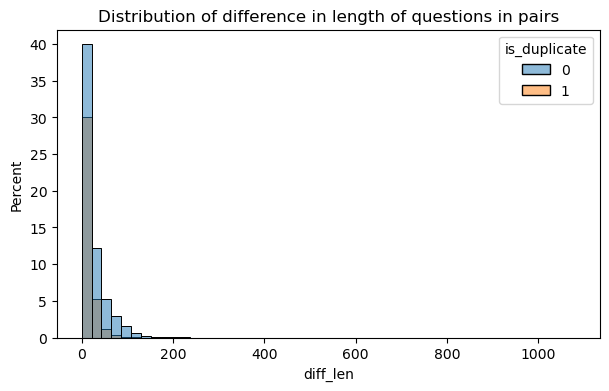

In [23]:
df_train['diff_len'] = abs(df_train['len_question1'] - df_train['len_question2'])
sns.histplot(df_train, x='diff_len', bins=50, hue='is_duplicate', stat='percent')
plt.title('Distribution of difference in length of questions in pairs')
plt.show()

In most cases, the length of question 1 and question 2 in pairs are similar or have difference approximatly 100 symbols in both directions(). But there are some cases where question 2 is significantly longer than question 1. And 

#### Word Count
The next step is to check the distribution of the number of words in each question.

In [24]:
train_qs_clean = (df_train['question1_clean'].to_list()
                  + df_train['question2_clean'].to_list())
test_qs_clean = (df_test['question1_clean'].to_list()
                 + df_test['question2_clean'].to_list())

In [25]:
train_qs_words_count = pd.Series(train_qs_clean).str.split().str.len()
test_qs_words_count = pd.Series(test_qs_clean).str.split().str.len()

In [26]:
train_qs_words_count.describe()

count    646858.000000
mean         11.044756
std           5.870461
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

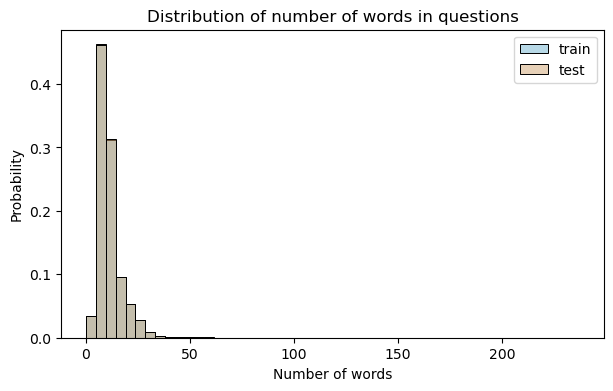

In [64]:
sns.histplot(train_qs_words_count,
             bins=50,
             color=palette[0],
             alpha=0.5,
             stat='probability',
             label='train')

sns.histplot(test_qs_words_count,
             bins=50,
             color=palette[1],
             alpha=0.5,
             stat='probability',
             label='test')

plt.title('Distribution of number of words in questions')
plt.xlabel('Number of words')
plt.legend()
plt.show()

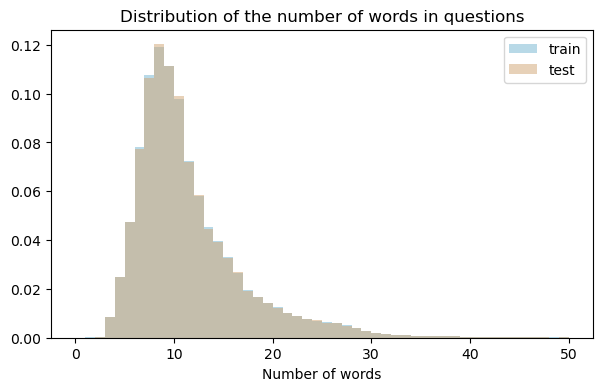

In [ ]:
plt.hist(train_qs_words_count, bins=50,
         color=palette[0], alpha=0.5,
         density=True, range=[0, 50], label='train')
plt.hist(test_qs_words_count, bins=50,
         color=palette[1], alpha=0.5,
         density=True, range=[0, 50], label='test')
plt.legend()
plt.title('Distribution of the number of words in questions')
plt.xlabel('Number of words')
plt.show()

Distribution of the number of words in each question is similar for train and test sets.

The most common number of words in a question is 10, and the maximum number of words in train set is 237. The distribution is right-skewed, with a long tail on the right side.

In [27]:
df_train['count_words_qs1'] = df_train['question1_clean'].str.split().str.len()
df_train['count_words_qs2'] = df_train['question2_clean'].str.split().str.len()
df_train['diff_count_words'] = abs(df_train['count_words_qs1']
                                   - df_train['count_words_qs2'])

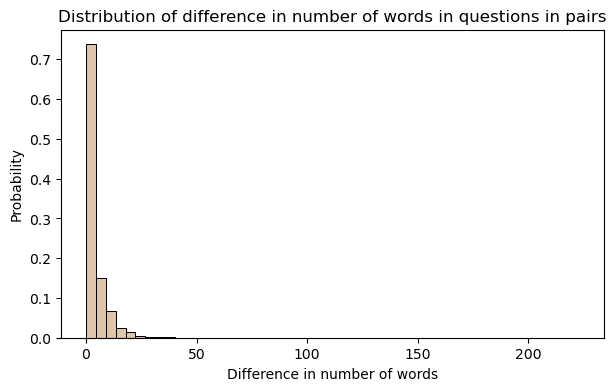

In [28]:
sns.histplot(df_train['diff_count_words'],
             bins=50, color='tan', stat='probability')
plt.title('Distribution of difference in number of words in questions in pairs')
plt.xlabel('Difference in number of words')
plt.show()

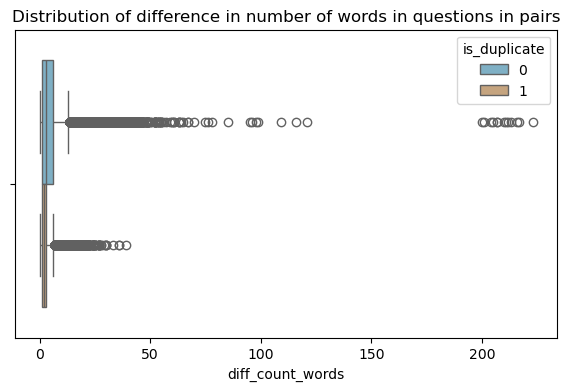

In [29]:
sns.boxplot(df_train, x='diff_count_words', hue='is_duplicate', palette=palette)
plt.title('Distribution of difference in number of words in questions in pairs')
plt.show()

The difference between the number of words in question 1 and question 2 is not significant for pairs of duplicate questions. However, for pairs of non-duplicate questions, the difference is more significant. In most cases, the number of words in question 1 is less than the number of words in question 2. 

#### Unique Words Count
The next step is to check the distribution of the number of words in each question. 

In [30]:
train_qs_unique_words_count = (pd.Series(train_qs_clean)
                               .apply(lambda x: len(set(x.split()))))
test_qs_unique_words_count = (pd.Series(test_qs_clean)
                              .apply(lambda x: len(set(x.split()))))

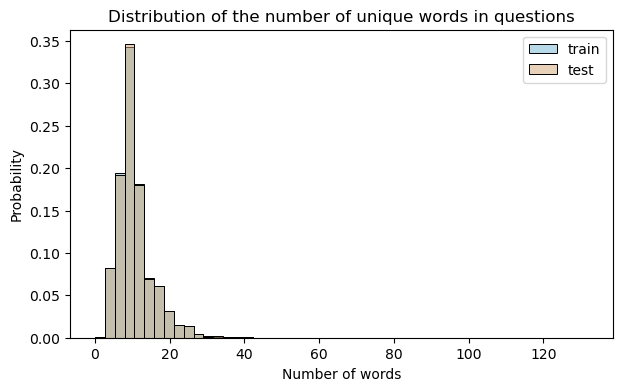

In [31]:
sns.histplot(train_qs_unique_words_count,
             bins=50,
             color=palette[0],
             alpha=0.5,
             stat='probability',
             label='train')
sns.histplot(test_qs_unique_words_count,
             bins=50,
             color=palette[1],
             alpha=0.5,
             stat='probability',
             label='test')
plt.title('Distribution of the number of unique words in questions')
plt.xlabel('Number of words')
plt.legend()
plt.show()

In [32]:
df_train['count_unique_words_qs1'] = (df_train['question1_clean']
                                      .apply(lambda x: len(set(x.split()))))
df_train['count_unique_words_qs2'] = (df_train['question2_clean']
                                      .apply(lambda x: len(set(x.split()))))
df_train['diff_count_unique_words'] = abs(df_train['count_unique_words_qs1']
                                          - df_train['count_unique_words_qs2'])

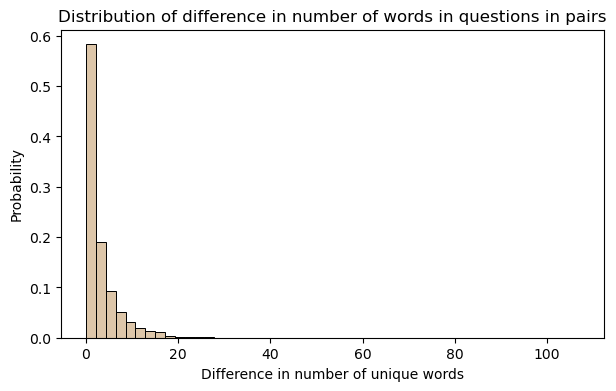

In [33]:
sns.histplot(df_train['diff_count_unique_words'],
             bins=50,
             color='tan',
             stat='probability')
plt.title('Distribution of difference in number of words in questions in pairs')
plt.xlabel('Difference in number of unique words')
plt.show()

The difference between the number of unique words in question 1 and question 2 is not significant. In most cases, the difference is around 25 words. Also in most cases, the number of unique words in question 1 is less than the number of unique words in question 2. 

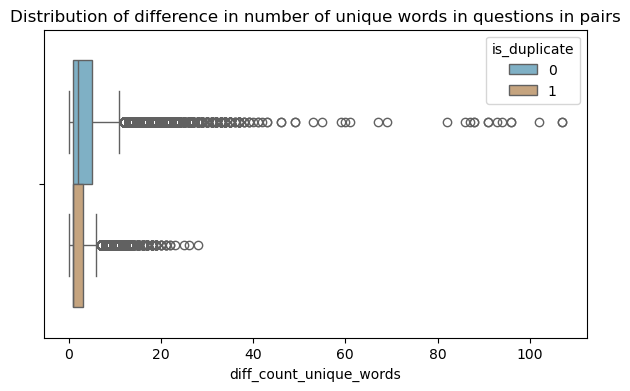

In [34]:
sns.boxplot(df_train, x='diff_count_unique_words',
            hue='is_duplicate',
            palette=palette)
plt.title('Distribution of difference in number of unique words in questions in pairs')
plt.show()

### Semantic Analysis

In [38]:
count_question_marks = pd.Series(train_qs).apply(
    lambda x: len([c for c in str(x) if c == '?'])
)

count_exclamation_marks = pd.Series(train_qs).apply(
    lambda x: len([c for c in str(x) if c == '!'])
)

count_dots = pd.Series(train_qs).apply(
    lambda x: len([c for c in str(x) if c == '.'])
)

count_punctuations = pd.Series(train_qs).apply(
    lambda x: len([c for c in str(x) if c in string.punctuation])
)

count_numbers = pd.Series(train_qs).apply(
    lambda x: len([c for c in str(x) if c.isdigit()])
)

In [39]:
print('Count of question marks in questions:')
print('most common:', count_question_marks.mode()[0])
print('max:', count_question_marks.max())

print('\nCount of exclamation marks in questions:')
print('most common:', count_exclamation_marks.mode()[0])
print('max:', count_exclamation_marks.max())

print('\nCount of dots in questions:')
print('most common:', count_dots.mode()[0])
print('max:', count_dots.max())

print('\nCount of punctuations marks in questions:')
print('most common:', count_punctuations.mode()[0])
print('max:', count_punctuations.max())

print('\nCount of numbers in questions:')
print('most common:', count_numbers.mode()[0])
print('max:', count_numbers.max())

Count of question marks in questions:
most common: 1
max: 9

Count of exclamation marks in questions:
most common: 0
max: 4

Count of dots in questions:
most common: 0
max: 23

Count of punctuations marks in questions:
most common: 1
max: 120

Count of numbers in questions:
most common: 0
max: 40


In [40]:
count_words_upper = pd.Series(train_qs).apply(
    lambda x: len([w for w in str(x).split() if w.isupper()])
)

count_words_title = pd.Series(train_qs).apply(
    lambda x: len([w for w in str(x).split() if w.istitle()])
)

In [41]:
print('Count of words in upper case:')
print('most common:', count_words_upper.mode()[0])
print('max:', count_words_upper.max())

print('\nCount of words in title case:')
print('most common:', count_words_title.mode()[0])
print('max:', count_words_title.max())

Count of words in upper case:
most common: 0
max: 31

Count of words in title case:
most common: 1
max: 55


### Matching Words
The next step is to check the distribution of the number of matching words in each question. We will find matching words in each pair of questions, calculate its number and plot the distribution.

In [42]:
def get_match_words(q1, q2):
    """
    Function to find the common words between two questions
    Args:
        q1: first question
        q2: second question
    Return:
        common words, match ratio
    """
    q1 = set(q1.split())
    q2 = set(q2.split())
    match_words =  list(q1.intersection(q2))
    count_match_words = len(match_words)
    return match_words, count_match_words

In [43]:
df_train[['match_words', 'count_match_words']] = df_train.apply(
    lambda x: get_match_words(x['question1_clean'], x['question2_clean']),
    axis=1,
    result_type='expand'
)

In [44]:
df_train[['match_words', 'count_match_words', 'is_duplicate']]

,match_words,count_match_words,is_duplicate
id,,,
332278,[the],1,0
196656,"[management, practical, strategic, what]",4,0
113125,"[answers, is]",2,0
266232,"[the, india, place, which, to, in, best]",7,0
122738,"[people, many, quora, on, why, google, questions]",7,1
...,...,...,...
111701,"[the, true, and, what, to, they, stereotypes, ...",13,0
90934,"[the, and, ever, seen, advertisements, of, hav...",9,0
363857,"[road, a, aurangzeb]",3,0


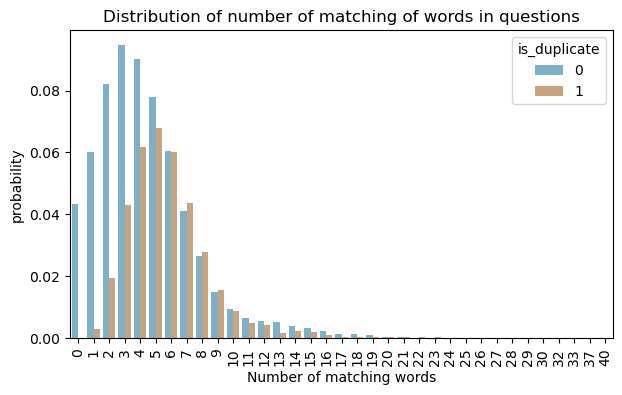

In [45]:
sns.countplot(df_train, x='count_match_words', hue='is_duplicate',
              palette=palette, stat='probability')
plt.title('Distribution of number of matching of words in questions')
plt.xlabel('Number of matching words')
plt.xticks(rotation=90)
plt.show()

- The pairs of duplicate questions have more matching words than the pairs of non-duplicate questions. The distribution is right-skewed, with a long tail on the right side. 
- The most common number of matching words in a pair of questions is 3 for not duplicated questions and 5 for duplicated questions.
- However, the pairs with more than 10 matching words are frequently not duplicated.
- The maximum number of matching words in a pair of questions is 40.

### Most Common Words
Let's find the most common words in the questions. This can help us understand the vocabulary used in the dataset and identify any potential preprocessing steps needed for text analysis.

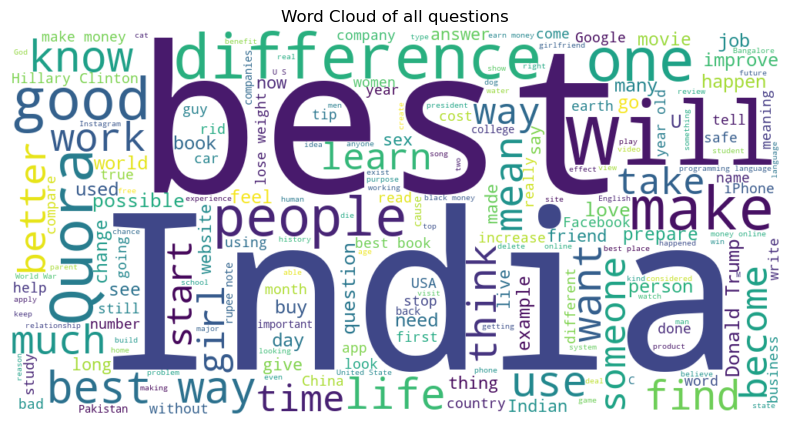

In [46]:
cloud = WordCloud(width=1000,
                  height=500,
                  background_color='white',
                  random_state=7).generate(' '.join(train_qs))
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of all questions')
plt.show()